<a href="https://colab.research.google.com/github/Salma-Kassem/optmization_techniques/blob/main/opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from  tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

In [ ]:
sheet_id = "1tCD9oS9iHd86CyriAjC9Aqoi6ymECeph1fO2UGALaFo"
sheet_name = "global_cancer_patients_2015_2024"  # Or your specific sheet name
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(csv_url)
df.head()  # Display first few rows


,Patient_ID,Age,Gender,Country_Region,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Cancer_Type,Cancer_Stage,Treatment_Cost_USD,Survival_Years,Target_Severity_Score
0,PT0000000,71,Male,UK,2021,6.4,2.8,9.5,0.9,8.7,Lung,Stage III,62913.44,5.9,4.92
1,PT0000001,34,Male,China,2021,1.3,4.5,3.7,3.9,6.3,Leukemia,Stage 0,12573.41,4.7,4.65
2,PT0000002,80,Male,Pakistan,2023,7.4,7.9,2.4,4.7,0.1,Breast,Stage II,6984.33,7.1,5.84
3,PT0000003,40,Male,UK,2015,1.7,2.9,4.8,3.5,2.7,Colon,Stage I,67446.25,1.6,3.12
4,PT0000004,43,Female,Brazil,2017,5.1,2.8,2.3,6.7,0.5,Skin,Stage III,77977.12,2.9,3.62


In [ ]:
# Check unique values in Cancer_Stage before mapping
print(df['Cancer_Stage'].unique())

# Check unique values in Gender before mapping
print(df['Gender'].unique())

['Stage III' 'Stage 0' 'Stage II' 'Stage I' 'Stage IV']
['Male' 'Female' 'Other']


In [ ]:
df = df.drop(columns=['Patient_ID']) #Patient_ID

stage_mapping = {                          #Cancer_Stage
    'Stage 0': 0,
    'Stage I': 1,
    'Stage II': 2,
    'Stage III': 3,
    'Stage IV': 4,
}
df['Cancer_Stage'] = df['Cancer_Stage'].map(stage_mapping)

gender_mapping = {'Male': 0, 'Female': 1 ,'Other': 2, }        #Gender
df['Gender'] = df['Gender'].map(gender_mapping)

#one-hot vector
df = pd.get_dummies(df, columns=['Country_Region'], drop_first=True) #Country_Region

df = pd.get_dummies(df, columns=['Cancer_Type'], drop_first=True) #Cancer_Type

#StandardScaler
num_cols = ['Age', 'Year', 'Genetic_Risk', 'Air_Pollution', 'Alcohol_Use', 'Smoking', 'Obesity_Level']
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

#Scale target
y = df[['Treatment_Cost_USD', 'Survival_Years', 'Target_Severity_Score']]
target_scaler = MinMaxScaler()
y = target_scaler.fit_transform(y)

X = df.drop(columns=['Treatment_Cost_USD', 'Survival_Years', 'Target_Severity_Score'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_test.shape,y_val.shape)

(36000, 25) (4000, 25) (10000, 25)
(10000, 3) (4000, 3)


In [ ]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32) #convert to tensors
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [ ]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
def build_model2(optimizer): #with regularization
     model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
         Dropout(0.2),
        Dense(3)  # Predict 3 targets: Treatment_Cost_USD, Survival_Years, Target_Severity_Score
        #It performs: y=Wx+b, just like linear regression.
    ])
     model.compile(optimizer=optimizer, loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanSquaredError(name='mse')])

     return model

In [ ]:
def convergence_speed(history, epochs_to_consider=50):
    losses = history.history['loss'][:epochs_to_consider]
    speed = (losses[0] - losses[-1]) / epochs_to_consider
    return speed

In [ ]:
class BatchLossPlotter(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.batch_losses = []

    def on_train_batch_end(self, batch, logs=None):
        if logs and 'loss' in logs:
            self.batch_losses.append(logs['loss'])

    def on_train_end(self, logs=None):
        if self.batch_losses:
            plt.figure(figsize=(10, 5))
            plt.plot(self.batch_losses)
            plt.xlabel('Batch')
            plt.ylabel('Loss')
            plt.title('Training Loss per Batch')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print("No batch losses recorded.")

In [ ]:
import matplotlib.pyplot as plt
batch_plotter = BatchLossPlotter()
model_adam = build_model2(tf.keras.optimizers.Adam(learning_rate=0.005,beta_1=0.92, beta_2=0.995,epsilon=1e-08))
history_adam = model_adam.fit(X_train, y_train, batch_size = 64 ,validation_data=(X_test,y_test), epochs=100, verbose=1)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0790 - mse: 0.0790 - val_loss: 0.0586 - val_mse: 0.0586
Epoch 2/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0582 - mse: 0.0582 - val_loss: 0.0583 - val_mse: 0.0583
Epoch 3/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0576 - mse: 0.0576 - val_loss: 0.0581 - val_mse: 0.0581
Epoch 4/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0577 - mse: 0.0577 - val_loss: 0.0591 - val_mse: 0.0591
Epoch 5/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0573 - mse: 0.0573 - val_loss: 0.0582 - val_mse: 0.0582
Epoch 6/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0575 - mse: 0.0575 - val_loss: 0.0583 - val_mse: 0.0583
Epoch 7/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0573 - mse: 0.0573 - val_loss: 0.0581 - val_mse: 0.0581
Epoch 8/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0573 - mse: 0.0573 - val_loss: 0.0580 - val_mse: 0.0580
Epoch 9/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss:

Average validation loss change per epoch: 0.000216
Average validation MSE change per epoch:  0.000216


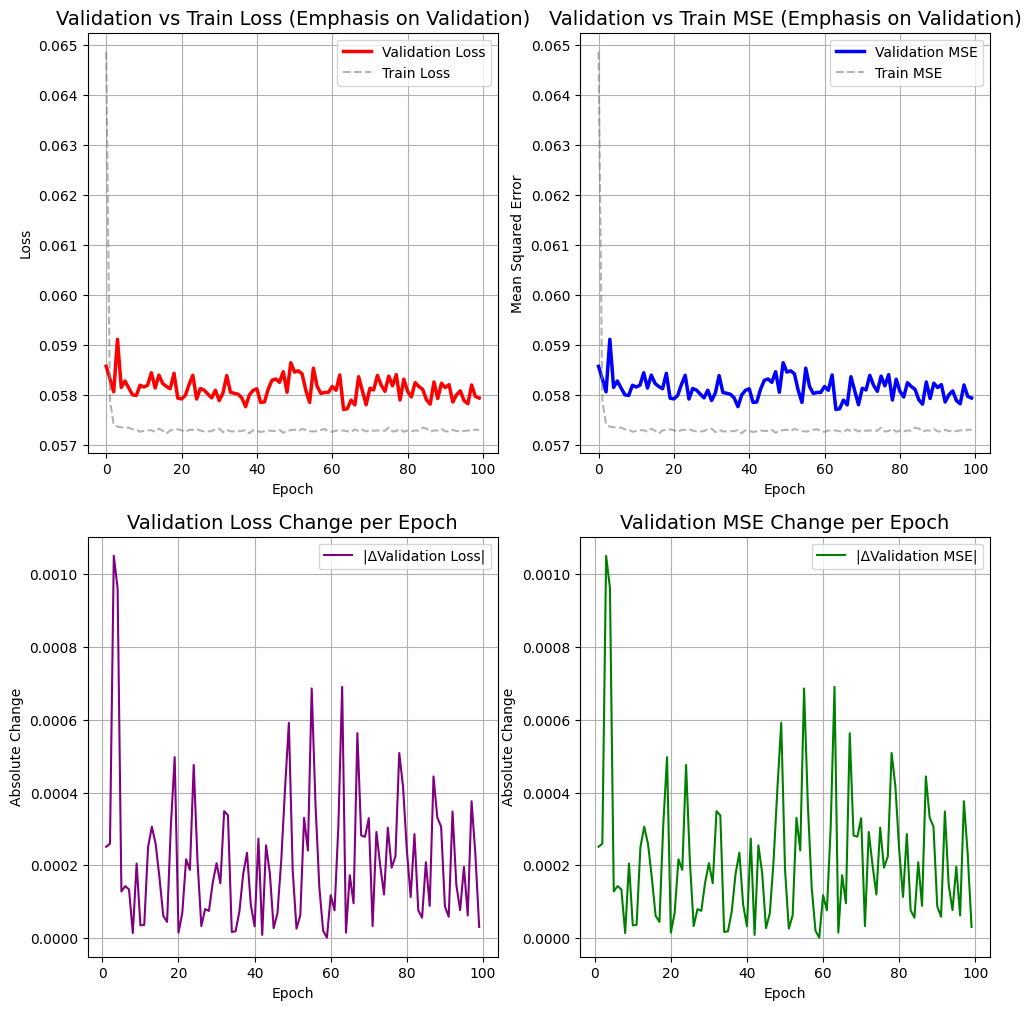

In [ ]:
import matplotlib.pyplot as plt

# Create figure
plt.figure(figsize=(18, 12))

# --- 1. Validation vs Train Loss ---
plt.subplot(2, 3, 1)
plt.plot(history_adam.history['val_loss'], label='Validation Loss', color='red', linewidth=2.5)
plt.plot(history_adam.history['loss'], label='Train Loss', color='gray', linestyle='--', alpha=0.6)
plt.title('Validation vs Train Loss (Emphasis on Validation)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- 2. Validation vs Train MSE ---
plt.subplot(2, 3, 2)
plt.plot(history_adam.history['val_mse'], label='Validation MSE', color='blue', linewidth=2.5)
plt.plot(history_adam.history['mse'], label='Train MSE', color='gray', linestyle='--', alpha=0.6)
plt.title('Validation vs Train MSE (Emphasis on Validation)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)

# --- 3. Validation Loss Change per Epoch ---
val_losses = history_adam.history['val_loss']
val_loss_change = [abs(val_losses[i] - val_losses[i - 1]) for i in range(1, len(val_losses))]

plt.subplot(2, 3, 4)
plt.plot(range(1, len(val_losses)), val_loss_change, label='|ΔValidation Loss|', color='purple')
plt.title('Validation Loss Change per Epoch', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Absolute Change')
plt.legend()
plt.grid(True)

# --- 4. Validation MSE Change per Epoch ---
val_mse = history_adam.history['val_mse']
val_mse_change = [abs(val_mse[i] - val_mse[i - 1]) for i in range(1, len(val_mse))]

plt.subplot(2, 3, 5)
plt.plot(range(1, len(val_mse)), val_mse_change, label='|ΔValidation MSE|', color='green')
plt.title('Validation MSE Change per Epoch', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Absolute Change')
plt.legend()
plt.grid(True)



# --- Print Summary Stats ---
avg_val_loss_change = sum(val_loss_change) / len(val_loss_change)
avg_val_mse_change = sum(val_mse_change) / len(val_mse_change)

print(f"Average validation loss change per epoch: {avg_val_loss_change:.6f}")
print(f"Average validation MSE change per epoch:  {avg_val_mse_change:.6f}")


In [ ]:
import matplotlib.pyplot as plt
sgd=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9,nesterov=True)
model_sgd = build_model2(sgd)
history_sgd = model_sgd.fit(X_train, y_train, batch_size = 32 ,validation_data=(X_test,y_test), epochs=100, verbose=1)






Epoch 1/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0692 - mse: 0.0692 - val_loss: 0.0590 - val_mse: 0.0590
Epoch 2/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0587 - mse: 0.0587 - val_loss: 0.0606 - val_mse: 0.0606
Epoch 3/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0579 - mse: 0.0579 - val_loss: 0.0588 - val_mse: 0.0588
Epoch 4/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0577 - mse: 0.0577 - val_loss: 0.0597 - val_mse: 0.0597
Epoch 5/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0577 - mse: 0.0577 - val_loss: 0.0589 - val_mse: 0.0589
Epoch 6/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0577 - mse: 0.0577 - val_loss: 0.0587 - val_mse: 0.0587
Epoch 7/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0579 - mse: 0.0579 - val_loss: 0.0592 - val_mse: 0.0592
Epoch 8/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0578 - mse: 0.0578 - val_loss: 0.0584 - val_mse: 0.0584
Epoch 9/100
1125/1125 ━━━━━━━━━━

Average validation loss change per epoch: 0.000538
Average validation MSE change per epoch:  0.000538


<Figure size 1600x1200 with 0 Axes>

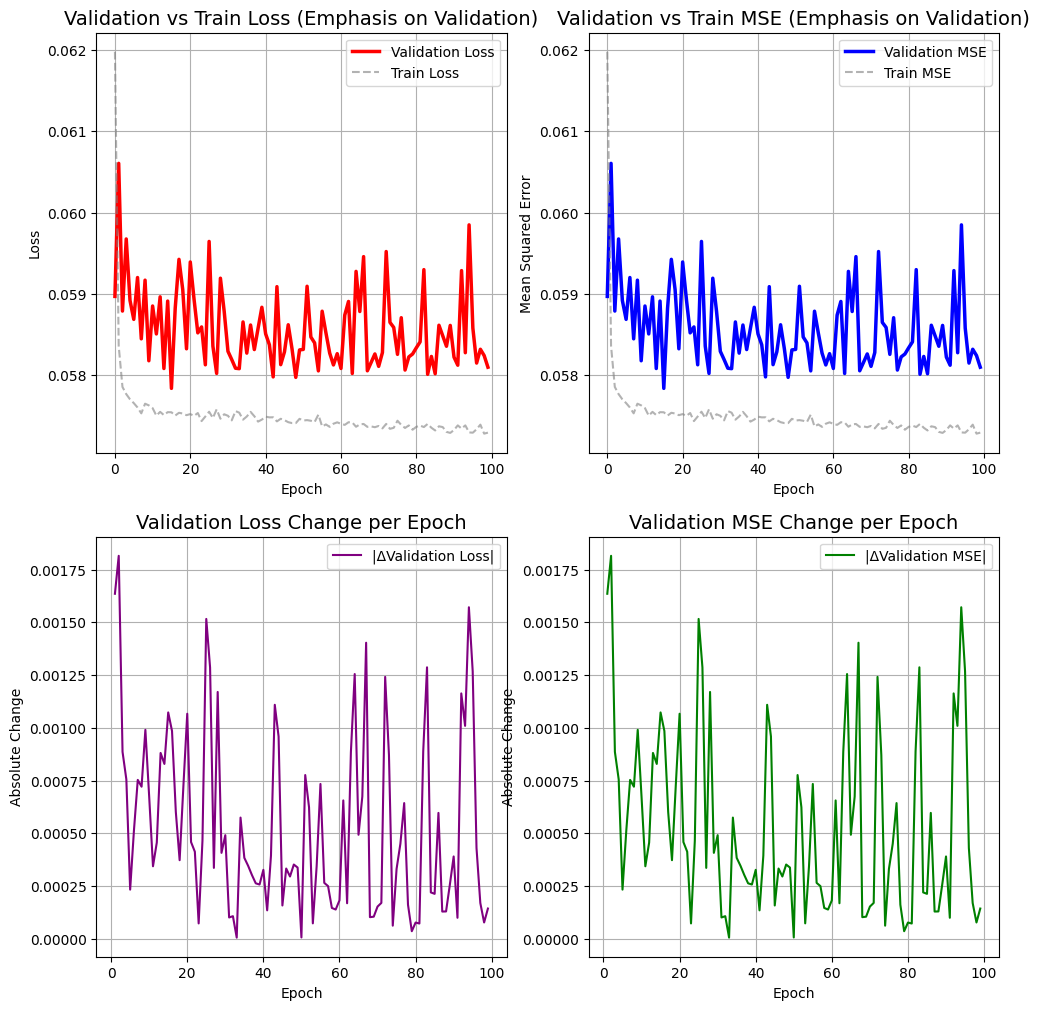

<Figure size 1600x1200 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Create figure
plt.figure(figsize=(18, 12))

# --- 1. Validation vs Train Loss ---
plt.subplot(2, 3, 1)
plt.plot(history_sgd.history['val_loss'], label='Validation Loss', color='red', linewidth=2.5)
plt.plot(history_sgd.history['loss'], label='Train Loss', color='gray', linestyle='--', alpha=0.6)
plt.title('Validation vs Train Loss (Emphasis on Validation)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- 2. Validation vs Train MSE ---
plt.subplot(2, 3, 2)
plt.plot(history_sgd.history['val_mse'], label='Validation MSE', color='blue', linewidth=2.5)
plt.plot(history_sgd.history['mse'], label='Train MSE', color='gray', linestyle='--', alpha=0.6)
plt.title('Validation vs Train MSE (Emphasis on Validation)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)

# --- 3. Validation Loss Change per Epoch ---
val_losses = history_sgd.history['val_loss']
val_loss_change = [abs(val_losses[i] - val_losses[i - 1]) for i in range(1, len(val_losses))]

plt.subplot(2, 3, 4)
plt.plot(range(1, len(val_losses)), val_loss_change, label='|ΔValidation Loss|', color='purple')
plt.title('Validation Loss Change per Epoch', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Absolute Change')
plt.legend()
plt.grid(True)

# --- 4. Validation MSE Change per Epoch ---
val_mse = history_sgd.history['val_mse']
val_mse_change = [abs(val_mse[i] - val_mse[i - 1]) for i in range(1, len(val_mse))]

plt.subplot(2, 3, 5)
plt.plot(range(1, len(val_mse)), val_mse_change, label='|ΔValidation MSE|', color='green')
plt.title('Validation MSE Change per Epoch', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Absolute Change')
plt.legend()
plt.grid(True)


# --- Print Summary Stats ---
avg_val_loss_change = sum(val_loss_change) / len(val_loss_change)
avg_val_mse_change = sum(val_mse_change) / len(val_mse_change)

print(f"Average validation loss change per epoch: {avg_val_loss_change:.6f}")
print(f"Average validation MSE change per epoch:  {avg_val_mse_change:.6f}")
# Create figure for Loss,MSE
plt.figure(figsize=(16, 12))



In [ ]:
rms=tf.keras.optimizers.RMSprop(learning_rate=0.001,
    rho=0.9,            # decay factor for moving average of squared gradients
    momentum=0.0,       # try 0.9 if training is too slow
    epsilon=1e-07,
    centered=False      # use True if gradients are very noisy
                                )
model_rms=build_model2(rms)
history_rms = model_rms.fit(X_train, y_train, batch_size = 64 ,validation_data=(X_test,y_test), epochs=100, verbose=1)


Epoch 1/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0986 - mse: 0.0986 - val_loss: 0.0608 - val_mse: 0.0608
Epoch 2/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0614 - mse: 0.0614 - val_loss: 0.0589 - val_mse: 0.0589
Epoch 3/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0593 - mse: 0.0593 - val_loss: 0.0589 - val_mse: 0.0589
Epoch 4/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0584 - mse: 0.0584 - val_loss: 0.0582 - val_mse: 0.0582
Epoch 5/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0582 - mse: 0.0582 - val_loss: 0.0585 - val_mse: 0.0585
Epoch 6/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0576 - mse: 0.0576 - val_loss: 0.0584 - val_mse: 0.0584
Epoch 7/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0570 - mse: 0.0570 - val_loss: 0.0586 - val_mse: 0.0586
Epoch 8/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0572 - mse: 0.0572 - val_loss: 0.0587 - val_mse: 0.0587
Epoch 9/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/

Average validation loss change per epoch: 0.000206
Average validation MSE change per epoch:  0.000206


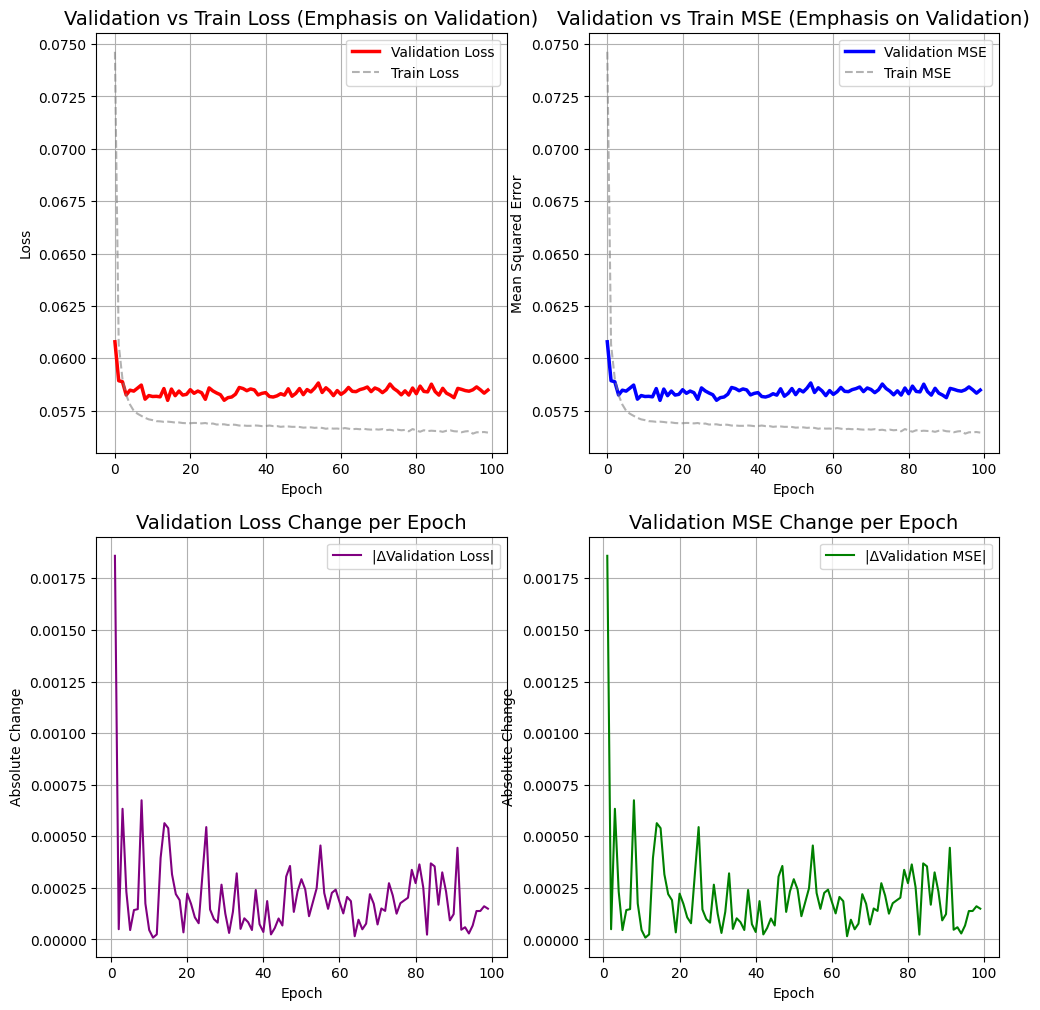

In [ ]:
import matplotlib.pyplot as plt

# Create figure
plt.figure(figsize=(18, 12))

# --- 1. Validation vs Train Loss ---
plt.subplot(2, 3, 1)
plt.plot(history_rms.history['val_loss'], label='Validation Loss', color='red', linewidth=2.5)
plt.plot(history_rms.history['loss'], label='Train Loss', color='gray', linestyle='--', alpha=0.6)
plt.title('Validation vs Train Loss (Emphasis on Validation)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- 2. Validation vs Train MSE ---
plt.subplot(2, 3, 2)
plt.plot(history_rms.history['val_mse'], label='Validation MSE', color='blue', linewidth=2.5)
plt.plot(history_rms.history['mse'], label='Train MSE', color='gray', linestyle='--', alpha=0.6)
plt.title('Validation vs Train MSE (Emphasis on Validation)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)

# --- 3. Validation Loss Change per Epoch ---
val_losses = history_rms.history['val_loss']
val_loss_change = [abs(val_losses[i] - val_losses[i - 1]) for i in range(1, len(val_losses))]

plt.subplot(2, 3, 4)
plt.plot(range(1, len(val_losses)), val_loss_change, label='|ΔValidation Loss|', color='purple')
plt.title('Validation Loss Change per Epoch', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Absolute Change')
plt.legend()
plt.grid(True)

# --- 4. Validation MSE Change per Epoch ---
val_mse = history_rms.history['val_mse']
val_mse_change = [abs(val_mse[i] - val_mse[i - 1]) for i in range(1, len(val_mse))]

plt.subplot(2, 3, 5)
plt.plot(range(1, len(val_mse)), val_mse_change, label='|ΔValidation MSE|', color='green')
plt.title('Validation MSE Change per Epoch', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Absolute Change')
plt.legend()
plt.grid(True)


# --- Print Summary Stats ---
avg_val_loss_change = sum(val_loss_change) / len(val_loss_change)
avg_val_mse_change = sum(val_mse_change) / len(val_mse_change)

print(f"Average validation loss change per epoch: {avg_val_loss_change:.6f}")
print(f"Average validation MSE change per epoch:  {avg_val_mse_change:.6f}")


In [ ]:
from tensorflow.keras.optimizers import Adagrad
adagrad= Adagrad(    learning_rate=0.05,              # Slightly higher for better early learning
    initial_accumulator_value=0.1,   # Default and typically fine
    epsilon=1e-7                     # Default, keep for stability
                     )
model_adagrad=build_model2(adagrad)
history_adagrad = model_adagrad.fit(X_train, y_train, batch_size = 64 ,validation_data=(X_test,y_test), epochs=100, verbose=1)


Epoch 1/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0825 - mse: 0.0825 - val_loss: 0.0618 - val_mse: 0.0618
Epoch 2/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0620 - mse: 0.0620 - val_loss: 0.0604 - val_mse: 0.0604
Epoch 3/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0606 - mse: 0.0606 - val_loss: 0.0597 - val_mse: 0.0597
Epoch 4/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0597 - mse: 0.0597 - val_loss: 0.0592 - val_mse: 0.0592
Epoch 5/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0593 - mse: 0.0593 - val_loss: 0.0590 - val_mse: 0.0590
Epoch 6/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0591 - mse: 0.0591 - val_loss: 0.0589 - val_mse: 0.0589
Epoch 7/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0586 - mse: 0.0586 - val_loss: 0.0590 - val_mse: 0.0590
Epoch 8/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0582 - mse: 0.0582 - val_loss: 0.0587 - val_mse: 0.0587
Epoch 9/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/

Average validation loss change per epoch: 0.000107
Average validation MSE change per epoch:  0.000107


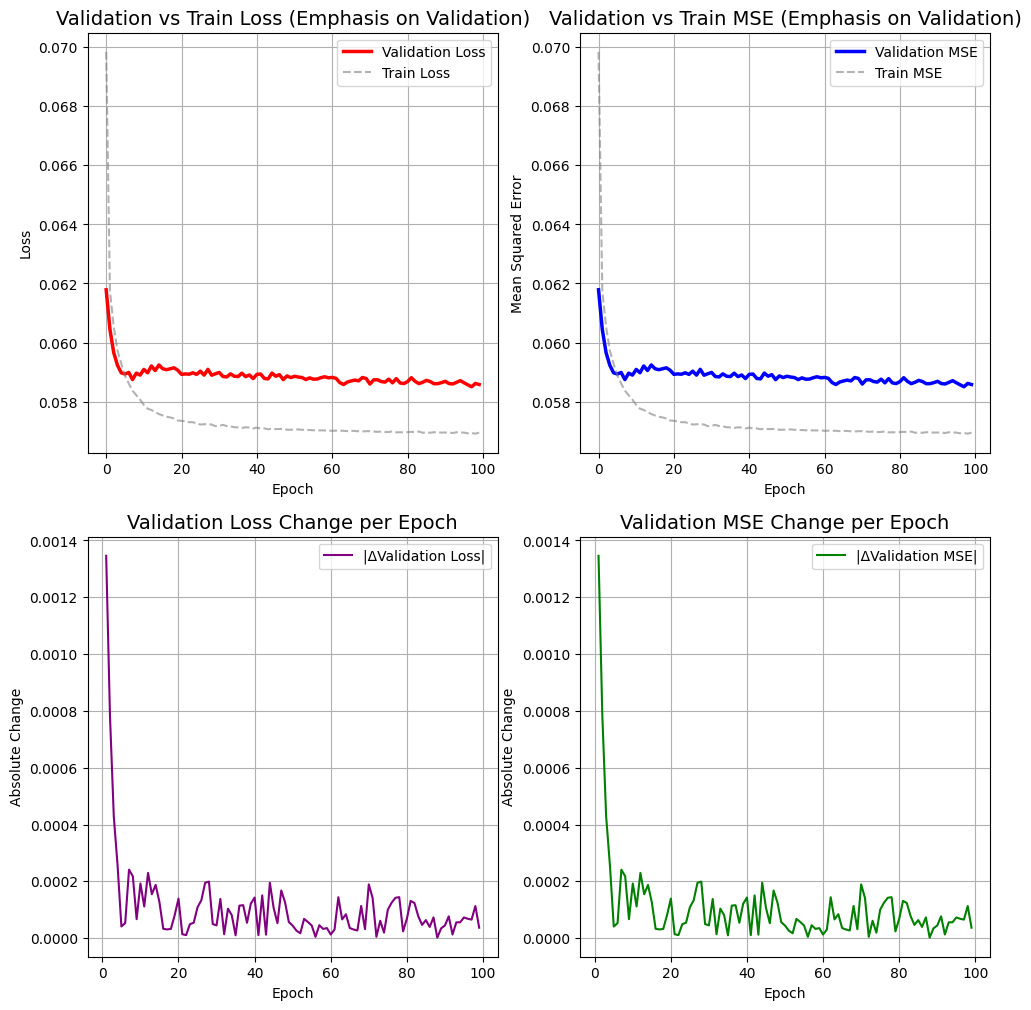

In [ ]:
import matplotlib.pyplot as plt

# Create figure
plt.figure(figsize=(18, 12))

# --- 1. Validation vs Train Loss ---
plt.subplot(2, 3, 1)
plt.plot(history_adagrad.history['val_loss'], label='Validation Loss', color='red', linewidth=2.5)
plt.plot(history_adagrad.history['loss'], label='Train Loss', color='gray', linestyle='--', alpha=0.6)
plt.title('Validation vs Train Loss (Emphasis on Validation)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- 2. Validation vs Train MSE ---
plt.subplot(2, 3, 2)
plt.plot(history_adagrad.history['val_mse'], label='Validation MSE', color='blue', linewidth=2.5)
plt.plot(history_adagrad.history['mse'], label='Train MSE', color='gray', linestyle='--', alpha=0.6)
plt.title('Validation vs Train MSE (Emphasis on Validation)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)

# --- 3. Validation Loss Change per Epoch ---
val_losses = history_adagrad.history['val_loss']
val_loss_change = [abs(val_losses[i] - val_losses[i - 1]) for i in range(1, len(val_losses))]

plt.subplot(2, 3, 4)
plt.plot(range(1, len(val_losses)), val_loss_change, label='|ΔValidation Loss|', color='purple')
plt.title('Validation Loss Change per Epoch', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Absolute Change')
plt.legend()
plt.grid(True)

# --- 4. Validation MSE Change per Epoch ---
val_mse = history_adagrad.history['val_mse']
val_mse_change = [abs(val_mse[i] - val_mse[i - 1]) for i in range(1, len(val_mse))]

plt.subplot(2, 3, 5)
plt.plot(range(1, len(val_mse)), val_mse_change, label='|ΔValidation MSE|', color='green')
plt.title('Validation MSE Change per Epoch', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Absolute Change')
plt.legend()
plt.grid(True)



# --- Print Summary Stats ---
avg_val_loss_change = sum(val_loss_change) / len(val_loss_change)
avg_val_mse_change = sum(val_mse_change) / len(val_mse_change)

print(f"Average validation loss change per epoch: {avg_val_loss_change:.6f}")
print(f"Average validation MSE change per epoch:  {avg_val_mse_change:.6f}")


Training with SGD optimizer...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0672 - mae: 0.2011 - val_loss: 0.0570 - val_mae: 0.1854
Epoch 2/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0575 - mae: 0.1866 - val_loss: 0.0570 - val_mae: 0.1853
Epoch 3/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0570 - mae: 0.1857 - val_loss: 0.0571 - val_mae: 0.1856
Epoch 4/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0572 - mae: 0.1859 - val_loss: 0.0569 - val_mae: 0.1851
Epoch 5/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0567 - mae: 0.1849 - val_loss: 0.0570 - val_mae: 0.1852
Epoch 6/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0567 - mae: 0.1850 - val_loss: 0.0569 - val_mae: 0.1849
Epoch 7/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0570 - mae: 0.1855 - val_loss: 0.0574 - val_mae: 0.1862
Epoch 8/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0570 - mae: 0.1857 - val_loss: 0.0572 - val_mae: 0.1856
Epoch 9/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss:

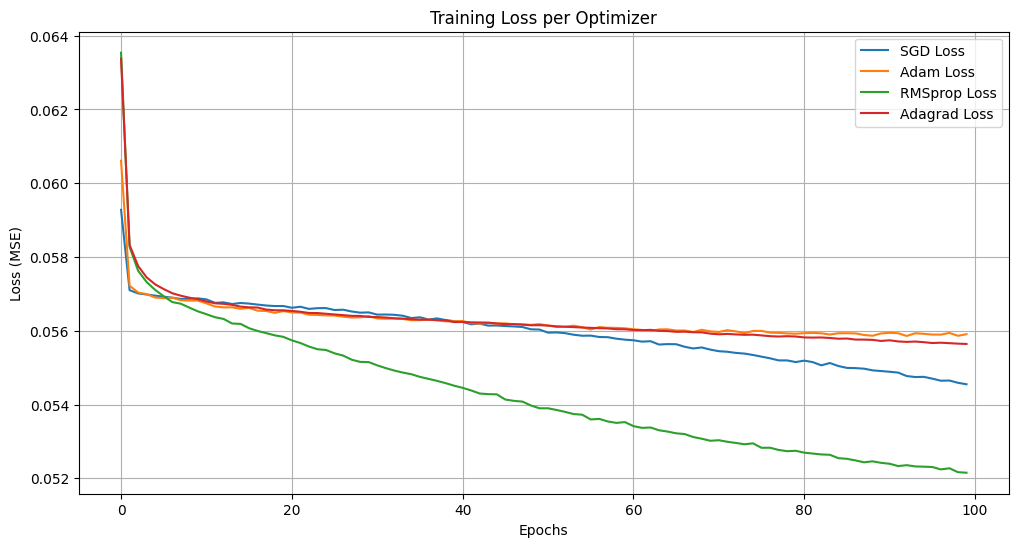

\nFinal Test Metrics for Each Optimizer:
SGD: Loss = 0.0599, MAE = 0.1893
Adam: Loss = 0.0588, MAE = 0.1884
RMSprop: Loss = 0.0628, MAE = 0.1926
Adagrad: Loss = 0.0583, MAE = 0.1879


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad
import matplotlib.pyplot as plt

# Define optimizers with YOUR hyperparameters
optimizers = {
    'SGD': SGD(learning_rate=0.1, momentum=0.9, nesterov=True),
    'Adam': Adam(learning_rate=0.005, beta_1=0.92, beta_2=0.995, epsilon=1e-08),
    'RMSprop': RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False),
    'Adagrad': Adagrad(learning_rate=0.05, initial_accumulator_value=0.1, epsilon=1e-7)
}

histories = {}
metrics = {}

def build_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(3)  # 3 output targets
    ])
    return model

for name, opt in optimizers.items():
    print(f"Training with {name} optimizer...")
    model = build_model(X_train.shape[1])
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    history = model.fit(X_train, y_train, epochs=100, batch_size=64,
                        validation_data=(X_val, y_val), verbose=1)
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    histories[name] = history
    metrics[name] = {'loss': loss, 'mae': mae}

# Plot training loss for all optimizers
plt.figure(figsize=(12, 6))
for name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{name} Loss')
plt.title('Training Loss per Optimizer')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Final metrics for each optimizer
print("\\nFinal Test Metrics for Each Optimizer:")
for name, metric in metrics.items():
    print(f"{name}: Loss = {metric['loss']:.4f}, MAE = {metric['mae']:.4f}")
